# RL Lab 03 - Part 1- Policy Evaluation 


CentraleSupélec Mention IA 2022-2023  
Hédi Hadiji 

## 1. Monte Carlo prediction

In these exercises, we will explore the **the Monte Carlo prediction algorithhm**. <br>The algorithm will be tested on Blackjack and a toy environment. <br>

This was discussed already in a TP1 on Frozen Lake.

### 1.1 Setup

In [ ]:
# imports
%matplotlib inline

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import sys

from collections import defaultdict
from itertools import product
from copy import deepcopy

import plotting
from utilities import * 

matplotlib.style.use('ggplot')

### BlackJack Rules

First, we define the Blackjack environment:

<ul>
<li />Black Jack is a card game where a player must obtain cards such that their sum is as close as possible to 21 without exceeding it.
<li />Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1. An ace is called 'usable' if the sum of the rest is less or equal to 10, in which case the value of the ace is 11. 
<li />In our example below, the player plays against a dealer. The dealer has a fixed policy of always asking for an additional card until the sum of their cards is above 17. 
<li /> Stationarity: This game is placed with an infinite deck (or with replacement).
</ul>

**Game Process:**  
<ol>
<li /> The game starts with each (player and dealer) having one face up and one
    face down card.
<li /> The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
<li />If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
</ol>
<img src="https://youngho92.github.io/images/RL/procedure.png" width="800">


**Model:**  
Sutton and Barto set the state of the environment to be:  
- the sum of the player's cards (between 4 and 21, the ace is 11 if its usable and 1 otherwise)
- the dealer's revealed card (between 1 and 11)
- the presence of a usable ace (a boolean) 

This make a total of $18 \cdot 11 \cdot 2 = 396$ possible states.


**Question: What information is lost when modelling things this way? Does it affect the power of the agent a lot?**  


Answer:  
We lose the identity of the cards. It does not matter because we assume that the deck of cards is infinite, so knowing which cards were seen does not affect the probability of hidden cards, only the sum matters.

In [ ]:
env = gym.make("Blackjack-v1", sab=True)

In [ ]:
print(env.reset())

### 1.2 Monte Carlo Prediction

As in TP1, we wish to estimate the value of a fixed policy. Here, we focus on state values.

We start by defining a policy that always hits when the sum is less than 1.

In [ ]:
class StickAbove20: 
    def __init__(self, action_space, observation_space, name='StickAbove20'):
        self.action_space = action_space
        self.observation_space = observation_space
        self.name = name
        
    def get_action(self, state):
        cards, dealer, usable = state
        if cards >= 20: 
            return 0 #Stick 
        else: 
            return 1 #Hit

In [ ]:
# Test 
env = gym.make("Blackjack-v1", sab=True)
agent = StickAbove20(env.action_space, env.observation_space)

state_list = [(20, 20, True), (15, 20, True), (21, 20, False), (5, 15, True)]
action_list = [0, 1, 0, 1]

for state, action in zip(state_list, action_list):
    assert(agent.get_action(state)==action)

print("Test passed")

Now we define an agent that records the history of observations to estimate the values. The learner keeps a running-mean of the values associated to every state. 

Recall from class and from TP1 how to compute the returns from a sequence of rewards. 

In [ ]:
class StickAbove20MCLearner(StickAbove20): 
    """
        Stores the data and computes the observed returns.
    """
    def __init__(self, action_space, observation_space, gamma = 0.99, name='Value Learner'):
        super().__init__(action_space, observation_space, name=name)
        
        self.current_episode_rewards = []
        self.current_episode_obs = []
        self.gamma = gamma
                
        self.values_estimates = defaultdict(lambda : 0.)
        self.number_of_values_in_estimate = defaultdict(lambda : 0)
        
    def update(self, obs, action, reward, terminated, next_obs):
        self.current_episode_rewards.append(reward)
        self.current_episode_obs.append(obs)
        
        if terminated:
            current_episode_returns = rewardseq_to_returns(self.current_episode_rewards, self.gamma) # From the utilities in TP1
            seen = []
            for i, s in enumerate(self.current_episode_obs): 
                if s not in seen: 
                    seen.append(s)
                    return_value = current_episode_returns[i]

                    # Update the estimates of the values with a running mean.
                    n = self.number_of_values_in_estimate[s]
                    self.values_estimates[s] = n / (n + 1) * self.values_estimates[s] + 1 / (n+1) * return_value
                    self.number_of_values_in_estimate[s] += 1
                                
            self.current_episode_rewards = []
            self.current_episode_obs = []

In [ ]:
# Remark: defaultdict(function) adds a default value to a dictionary when it's called with a non-existent key, b
# by calling the argument function. Check the code below for an example.

# In practice, it can be a bit dangerous to use because you lose the ability to catch key errors. But it is also super handy. To use with caution. 

#d = defaultdict(lambda : 0.)
#d['foo']
#d[0] = 1
#print(d)

In [ ]:
agent = StickAbove20MCLearner(env.action_space, env.observation_space)
N_episodes = 100_000

env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

plotting.plot_value_function(agent.values_estimates, title=f"{N_episodes} Steps")

Here is roughly what the values should look like

![Values from MC estimation](img/tp3_bj_mc_vals.png)

**Question**:
Comment on the graph   

Answer:  


The policy is good when the observed sum is around 10 (then hitting is not risky, and there is a chance you get a ten or 11)
and when the sum is above 20 (then you should really stick)


### 1.3 Monte Carlo prediction on multiple episodes

In this part we will analyze the effect of the number of episodes (num_episodes) on the learned value function.

In [ ]:
env = gym.make("Blackjack-v1", sab=True)
N_max = 200_000

for N_episodes in np.arange(1, N_max, step=int(N_max / 3)):
    agent = StickAbove20MCLearner(env.action_space, env.observation_space) #reset the agent
    env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)
    plotting.plot_value_function(agent.values_estimates, title=f"{N_episodes} Steps")

**Question**  What's the effect of the number of episodes (num_episodes) on the learned value function ?

Answer:  

Estimates become more accurate. 


## 2. Temporal Difference Prediction

Improving approximations using Bellman Iterations

From Sutton and Barto (chapter 6.1), the TD(0) algorithm for estimating V is as follows:  


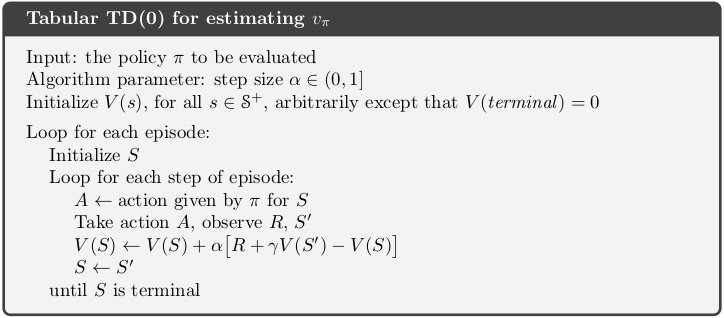

The idea is to gradually improve the estimation with interpolations of Bellman iterations.

### Implementation of TD(0)

Start by filling the following blanks in the code below. 

**Important: remember that the value of a terminal state is always 0.**

In [ ]:
class StickAbove20TDLearner(StickAbove20): 
    """
        Stores the data and computes the observed returns.
    """
    def __init__(self, 
                 action_space, 
                 observation_space, 
                 gamma=0.99,
                 lr=0.1, 
                 name='TD Value Prediction', 
                 v_init=0,
                ):
        super().__init__(action_space, observation_space, name=name)
        self.gamma = gamma
        self.v_init = v_init
        
        self.lr = lr
        
        self.reset()
        
    def update(self, obs, action, reward, terminated, next_obs):

        # Update self.values_estimates to implement the algorithm above.

        estimate_value_at_next_state = (not terminated) * self.values_estimates[next_obs]
        new_estimate = reward + self.gamma * estimate_value_at_next_state
    
        self.values_estimates[obs] = (
            (1 - self.lr) * self.values_estimates[obs] + self.lr * new_estimate
        )
        
    def reset(self): 
        self.values_estimates = defaultdict(lambda : self.v_init) # Dict that will map a state to its value

In [ ]:
env = gym.make("Blackjack-v1", sab=True)
agent = StickAbove20TDLearner(env.action_space, env.observation_space)

N_episodes = 10_000
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

plotting.plot_value_function(agent.values_estimates, title=f"{N_episodes} Steps")

In [ ]:
env = gym.make("Blackjack-v1", sab=True)
lr = 0.1
gamma = .99
N_episodes = 10000

agent = StickAbove20TDLearner(env.action_space, env.observation_space, gamma=gamma, lr=lr)
_, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

agent2 = StickAbove20MCLearner(env.action_space, env.observation_space, gamma=gamma)
_, agent2 = run_N_episodes(env, agent, N_episodes=N_episodes)

plotting.plot_value_function(agent.values_estimates)
plotting.plot_value_function(agent2.values_estimates)

## Evaluate a Random walk (Example 6.2 Sutton's book)

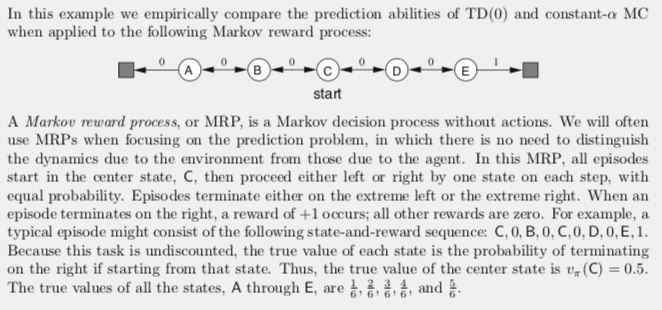

This environment is great for testing algorithms before applying them to more sophisticated cases. In general, you should always test your algorithms on the simplest environment available and increase gradually the complexity of the tests.

In [ ]:
from gymnasium.spaces import Discrete

class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0] # true values for gamma=1
    
    def __init__(self):
        self.observation_space = Discrete(7)
        self.action_space = Discrete(2)
        self.reset()

    def reset(self):
        self._state = 3
        self._terminated = False
        
        return self._state, {}

    def step(self, action):
        # Implement the environment by updating self._state and self._terminated, and computing the reward
        # Action 0 is go left and action 1 is go right.

        if action == 0: 
            self._state -= 1
        if action == 1: 
            self._state += 1
            
        reward = 0
        if self._state < 1:
            self._terminated = True
        if self._state > 5: 
            self._terminated = True
            reward = 1
                
        return self._state, reward, self._terminated, False, {}

In [ ]:
env = LinearEnv()

In [ ]:
# Test
env = LinearEnv()
action_list = [0, 1, 0, 1, 1, 1, 1,]
output_list = [(2, 0, False, False, {}),
                (3, 0, False, False, {}),
                (2, 0, False, False, {}),
                (3, 0, False, False, {}),
                (4, 0, False, False, {}),
                (5, 0, False, False, {}),
                (6, 1, True, False, {}),
                ]

for action, output in zip(action_list, output_list): 
    assert(output == env.step(action))
    
print("Test passed")

 We define again the agents. Note that it's mostly copy-pasted from above. (In practice, we could factor the code differently, by implementing the get_action in the inherited classes.)

In [ ]:
class RandomAgent:
    def __init__(self, action_space, observation_space, name=""):
        self.action_space = action_space
        self.observation_space = observation_space
        self.name = name
        
    def get_action(self, state):
        return self.action_space.sample()
    
    def update(self, *data):
        return 

class RandomMCLearner(RandomAgent): 
    """
        Stores the data and computes the observed returns.
    """
    def __init__(self,
                 action_space,
                 observation_space,
                 gamma=0.99, 
                 name='TD Value Prediction'
                ):
        
        super().__init__(action_space, observation_space, name=name)
        self.gamma = gamma
        
        self.reset()
        
        
    def update(self, obs, action, reward, terminated, next_obs):
        super().update(obs, action, reward, terminated, next_obs)
        self.current_episode_rewards.append(reward)
        self.current_episode_obs.append(obs)
        
        if terminated:
            current_episode_returns = rewardseq_to_returns(self.current_episode_rewards, self.gamma)
            seen = []
            for i, s in enumerate(self.current_episode_obs): 
                if s not in seen: 
                    seen.append(s)
                    return_value = current_episode_returns[i]
                    
                    n = self.number_of_values_in_estimate[s]
                    self.values_estimates[s] = n / (n + 1) * self.values_estimates[s] + 1 / (n+1) * return_value
                    self.number_of_values_in_estimate[s] += 1
                                
            self.current_episode_rewards = []
            self.current_episode_obs = []
            
    def reset(self):
        self.current_episode_rewards = []
        self.current_episode_obs = []
        
        self.values_estimates = defaultdict(lambda : 0.)
        self.number_of_values_in_estimate = defaultdict(lambda : 0)

class RandomTDLearner(RandomAgent): 
    """
        Stores the data and computes the observed returns.
    """
    def __init__(self, 
                 action_space, 
                 observation_space, 
                 gamma=0.99, 
                 lr=0.1,
                 v_init=0.,
                 name='TD Value Prediction'):
        super().__init__(action_space, observation_space, name=name)
        self.gamma = gamma
        self.lr = lr
        self.v_init = v_init
        
        self.reset()
        
    def update(self, obs, action, reward, terminated, next_obs):
        super().update(obs, action, reward, terminated, next_obs)
        
        estimate_value_at_next_state = (not terminated) * self.values_estimates[next_obs]
        new_estimate = reward + self.gamma * estimate_value_at_next_state
        
        self.values_estimates[obs] = (
            (1 - self.lr) * self.values_estimates[obs] 
            + self.lr * new_estimate
        )
    
    def reset(self):
        self.values_estimates = defaultdict(lambda : self.v_init)

#### For 10 episodes

In [ ]:
env = LinearEnv()
lr = 0.1
gamma = 1.
N_episodes = 10

agent = RandomTDLearner(env.action_space, env.observation_space, gamma=gamma, lr=lr)
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

plotting.plot_RW(agent.values_estimates)

#### Evolution of the value estimates over time:

Let us compare the evolution of the quality of the estimates over time. 

**Question** Play around with the values of v_init. What do you observe? 

Answer: 

The closer v_init is to the true value, the faster the convergence. However even if v_init is very far from the true value (e.g. v_init=100), we eventually have convergence.

In [ ]:
env = LinearEnv()
agent = RandomTDLearner(env.action_space, env.observation_space, v_init=100, lr=.1, gamma=.999)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(LinearEnv.V_true[1:-1], color='black', label='True Value')

Ns = np.array([1, 9, 90, 900, 9000])

total = 0
for N_episodes in  Ns:
    total += N_episodes
    _, agent = run_N_episodes(env, agent, N_episodes=N_episodes)
    ax.plot(to_arr(agent.values_estimates)[1:-1], label=f'n = {total}')

ax.set_title('Estimated Value, Temporal Difference')
ax.set_xlabel('State')
ax.legend()

plt.show()

## TD vs MC comparison on Random Walk

In [ ]:
env = LinearEnv()
agent = RandomMCLearner(env.action_space, env.observation_space, gamma=1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(LinearEnv.V_true[1:-1], color='black', label='True Value')
Ns = np.array([1, 9, 90, 900, 9000])

total = 0
for N_episodes in  Ns:
    total += N_episodes
    _, agent = run_N_episodes(env, agent, N_episodes=N_episodes)
    ax.plot(to_arr(agent.values_estimates)[1:-1], label=f'n = {total}')

ax.set_title('Estimated Value, Monte-Carlo')
ax.set_xlabel('State')
ax.legend()

plt.show()

**Question:**  Interpret the graph above.

Answer: 

Monte-Carlo is a little more accurate for large values and converges faster in this case.

## Learning rate

We now run a little experiment to try and quantify the error of Temporal Difference and illustrate the impact of the learning rate.

In [ ]:
def run_experiment(agent, env, nb_runs, ep):
    V_runs = []
    for _ in range(nb_runs):
        agent.reset()
        _, agent = run_N_episodes(env, agent, N_episodes=ep)
        
        V_runs.append(deepcopy(to_arr(agent.values_estimates)))
        
    V_runs = np.array(V_runs)  # dims: [nb_runs, nb_episodes, nb_states=7]
    
    V_runs = V_runs[:,1:-1]  # remove data about terminal states (which is always zero anyway)
    error_to_true = V_runs - env.V_true[1:-1]
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)  # avg over states
    root_mean_squared_error = np.sqrt(mean_squared_error)
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs  # this is data that goes directly on the plot

And finally the experiments

In [ ]:
lrs = np.linspace(0,.3,5)
N_max = 200
run_lengths = np.arange(1, N_max, int(N_max / 20))
N_runs = 100
rmses = {}
for lr, N_episodes in product(lrs, run_lengths):
    agentTD = RandomTDLearner(*spaces, lr=lr)
    rmses[lr, N_episodes] = run_experiment(agentTD, env, N_runs, N_episodes)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i, lr in enumerate(lrs):
    ax.plot(run_lengths, [rmses[lr, N_episodes] for N_episodes in run_lengths], label=f'LR = {lr}')
ax.set_title('Empirical RMS error, averaged over tests')
ax.legend()
ax.set_xlabel('Walks / Episodes')
plt.tight_layout()
plt.show()

In [ ]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
#for i, N_episodes in enumerate(run_lengths):
#    ax.plot(lrs, [rmses[lr, N_episodes] for lr in lrs], label=f'N_episodes = {N_episodes}')
#ax.set_title('Empirical RMS error, averaged over tests')
#ax.legend()
#ax.set_xlabel('Learning Rate')
#plt.tight_layout()
#plt.show()

**Question**  Commment the graph above.

Answer:  

Larger learning rate means faster learning in initial rounds, but the error stops going down at a higher level.